In [39]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import csv
import time

In [40]:
batch_size = 32

LInputTarget = tf.keras.Input(dtype = tf.float32, shape = [256, 256, 3], name = 'Target')
with tf.name_scope("Encoder"):
    Lconv1_1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(LInputTarget) 
    Lconv1_2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(Lconv1_1) 
    Lpool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides = 2, padding = 'SAME')(Lconv1_2)

    Lconv2_1 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(Lpool1) 
    Lconv2_2 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(Lconv2_1) 
    Lpool2 = tf.keras.layers.MaxPool2D(pool_size=2, strides = 2, padding = 'SAME')(Lconv2_2)

    Lconv3_1 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(Lpool2) 
    Lconv3_2 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(Lconv3_1) 
    Lpool3 = tf.keras.layers.MaxPool2D(pool_size=2, strides = 2, padding = 'SAME')(Lconv3_2)

    Lconv4_1 = tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(Lpool3) 
    Lconv4_2 = tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(Lconv4_1) 
    Lpool4 = tf.keras.layers.MaxPool2D(pool_size=2, strides = 2, padding = 'SAME')(Lconv4_2)

    Lconv5_1 = tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(Lpool4) 
    Lconv5_2 = tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(Lconv5_1) 
    Lpool5 = tf.keras.layers.MaxPool2D(pool_size=2, strides = 2, padding = 'SAME')(Lconv5_2)
    
    modelEncoder = tf.keras.Model(inputs=LInputTarget, outputs=Lpool5, name="Unet model")

In [41]:
modelEncoder.summary()

Model: "Unet model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Target (InputLayer)          [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 128)       0

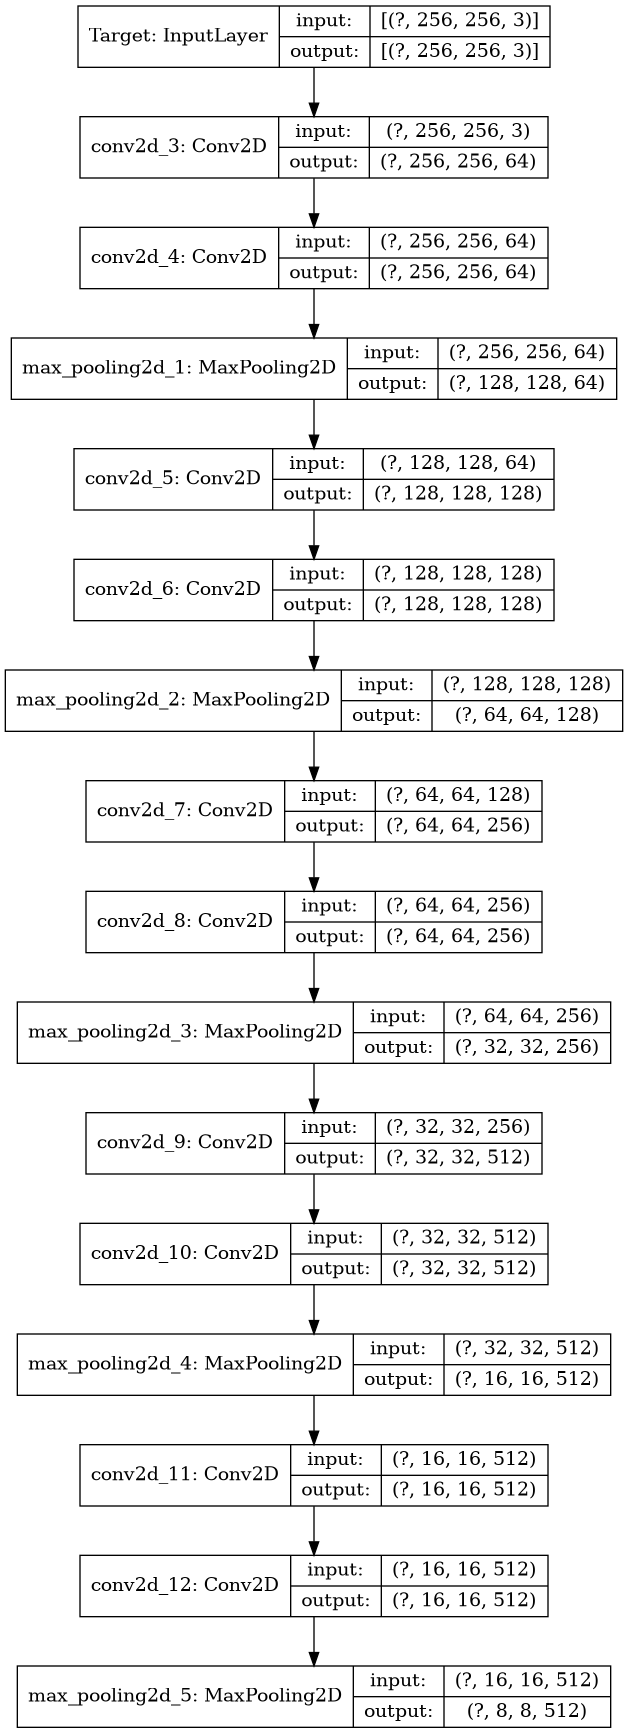

In [42]:
tf.keras.utils.plot_model(modelEncoder, "unet_encoder.png", show_shapes=True)

In [43]:
LInputQuery  = tf.keras.Input(dtype = tf.float32, shape = [64, 64, 3], name = 'Query')
with tf.name_scope("Conditional"):
    LCconv1_1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(LInputQuery) 
    LCconv1_2 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(LCconv1_1) 
    LCpool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides = 2, padding = 'SAME')(LCconv1_2)

    
    LCconv2_1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(LCpool1) 
    LCconv2_2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(LCconv2_1) 
    LCpool2 = tf.keras.layers.MaxPool2D(pool_size=2, strides = 2, padding = 'SAME')(LCconv2_2)


    LCconv3_1 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(LCpool2) 
    LCpool3 = tf.keras.layers.MaxPool2D(pool_size=2, strides = 2, padding = 'SAME')(LCconv3_1)

    
    LCconv4_1 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(LCpool3) 
    LCpool4 = tf.keras.layers.MaxPool2D(pool_size=2, strides = 2, padding = 'SAME')(LCconv4_1)

    
    LCconv5_1 = tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(LCpool4)  
    LCpool5 = tf.keras.layers.MaxPool2D(pool_size=2, strides = 2, padding = 'SAME')(LCconv5_1)
    
    LCconv6_1 = tf.keras.layers.Conv2D(filters = 512, kernel_size = 2, strides = 1, 
                   activation = tf.nn.relu)(LCpool5)
    LCoutput = LCconv6_1
    modelConditional = tf.keras.Model(inputs=LInputQuery, outputs=LCconv6_1, name="latent representation")

In [44]:
modelConditional.summary()

Model: "latent representation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Query (InputLayer)           [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 6

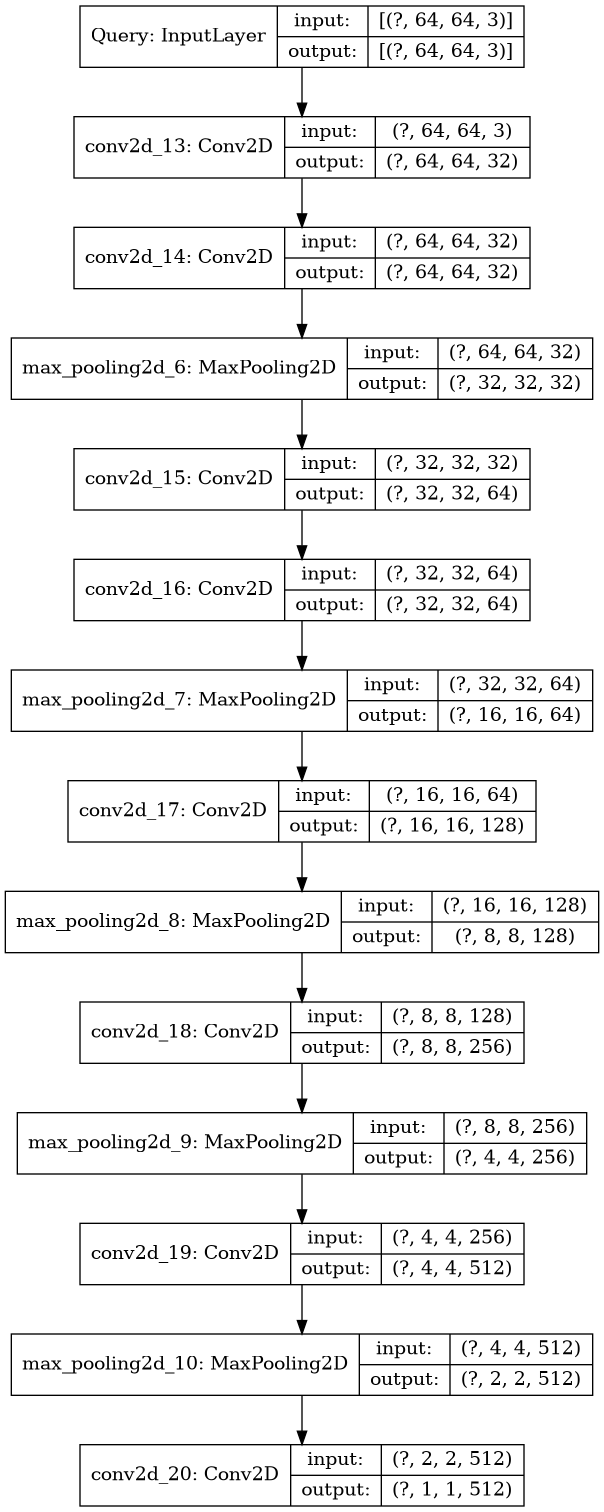

In [45]:
tf.keras.utils.plot_model(modelConditional, "unet_encoder.png", show_shapes=True)

In [46]:
#LInputIntermittent  = tf.keras.Input(dtype = tf.float32, shape = [8, 8, 1024], name = 'Encoded intermittent')
with tf.name_scope("Transcoder"):
    LDtiling8x8 = tf.keras.layers.UpSampling2D(size=(8, 8))(LCoutput) # [1,1,512] -> [8,8,512]
    LDconcat1_1 = tf.keras.layers.Concatenate(axis=-1)([Lpool5, LDtiling8x8]) # -> [8,8,1024]
    LDdeconv1_1 = tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(LDconcat1_1) # [8,8,1024] -> [8,8,512]
    LDdeconv1_2 = tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(LDdeconv1_1)  # [8,8,512]  -> [8,8,512]
    LDupsam1 = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size = 3,
                   strides=(2,2), padding='SAME', activation = tf.nn.relu)(LDdeconv1_2) # [8,8,512] -> [16,16,512]

    
    LDtiling16x16 = tf.keras.layers.UpSampling2D(size=(16, 16))(LCoutput) # [1,1,512] -> [16,16,512]
    LDconcat2_1 = tf.keras.layers.Concatenate(axis=-1)([Lpool4, LDtiling16x16]) # -> [16,16,1024]
    LDconv2 = tf.keras.layers.Conv2D(filters = 512, kernel_size = 1, strides = 1, padding='SAME',
                   activation=tf.nn.relu)(LDconcat2_1) # [ 16, 16, 1024 ] -> [ 16, 16, 512 ]
    LDconcat2_2 = tf.keras.layers.Concatenate(axis=-1)([LDupsam1, LDconv2]) # -> [ 16, 16, 1024 ]
    LDdeconv2_1 = tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(LDconcat2_2) # [16,16,1024] -> [16,16,512]
    LDdeconv2_2 = tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(LDdeconv2_1)  # [16,16,256]  -> [16,16,512]
    LDupsam2 = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size = 3,
                   strides=(2,2), padding='SAME', activation = tf.nn.relu)(LDdeconv2_2) # [16,16,512] -> [32,32,512]
    
    
    LDtiling32x32 = tf.keras.layers.UpSampling2D(size=(32, 32))(LCoutput) # [1,1,512] -> [32,32,512]
    LDconcat3_1 = tf.keras.layers.Concatenate(axis=-1)([Lpool3, LDtiling32x32]) # -> [32,32,1024]
    LDconv3 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 1, strides = 1, padding='SAME',
                   activation=tf.nn.relu)(LDconcat3_1) # -> [32, 32, 256]
    
    LDconcat3_2 = tf.keras.layers.Concatenate(axis=-1)([LDupsam2, LDconv3]) # -> [32,32,768]
    LDdeconv3_1 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(LDconcat3_2) # [32,32,768] -> [32,32,256]
    LDdeconv3_2 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(LDdeconv3_1)  # [32,32,256]  -> [32,32,256]
    LDupsam3 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size = 3,
                   strides=(2,2), padding='SAME', activation = tf.nn.relu)(LDdeconv3_2) # -> [64,64,256]
    
    
    LDtiling64x64 = tf.keras.layers.UpSampling2D(size=(64, 64))(LCoutput) # [1,1,512] -> [64,64,512]
    LDconcat4_1 = tf.keras.layers.Concatenate(axis=-1)([Lpool2, LDtiling64x64]) # -> [64,64,768]
    LDconv4 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 1, strides = 1, padding='SAME',
                   activation=tf.nn.relu)(LDconcat4_1) # -> [64, 64, 128]
    
    LDconcat4_2 = tf.keras.layers.Concatenate(axis=-1)([LDupsam3, LDconv4]) # -> [64,64,384]
    LDdeconv4_1 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(LDconcat4_2) # [64,64,384] -> [64,64,128]
    LDdeconv4_2 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(LDdeconv4_1)  # [64,64,128]  -> [64,64,128]
    LDupsam4 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size = 3,
                   strides=(2,2), padding='SAME', activation = tf.nn.relu)(LDdeconv4_2) # -> [128,128,128]
    
    
    LDtiling128x128 = tf.keras.layers.UpSampling2D(size=(128, 128))(LCoutput) # [1,1,512] -> [128,128,512]
    LDconcat5_1 = tf.keras.layers.Concatenate(axis=-1)([Lpool1, LDtiling128x128]) # -> [128,128,640]
    LDconv5 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 1, strides = 1, padding='SAME',
                   activation=tf.nn.relu)(LDconcat5_1) # -> [128, 128, 64]
    
    LDconcat5_2 = tf.keras.layers.Concatenate(axis=-1)([LDupsam4, LDconv5]) # -> [128,128,192]
    LDdeconv5_1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(LDconcat5_2) # [128,128,192] -> [128,128,64]
    LDdeconv5_2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu)(LDdeconv5_1)  # [128,128,64]  -> [128,128,64]
    LDupsam5 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size = 3,
                   strides=(2,2), padding='SAME', activation = tf.nn.relu)(LDdeconv5_2) # -> [256,256,64]
    LDoutput = tf.keras.layers.Conv2D(filters = 1, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu, name="Output")(LDupsam5)  # [256,256,64]  -> [256,256,1]
    modelUnet = tf.keras.Model(inputs=[LInputTarget, LInputQuery], outputs=[LDoutput], name="Unet")

In [47]:
modelUnet.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Target (InputLayer)             [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 64) 1792        Target[0][0]                     
__________________________________________________________________________________________________
Query (InputLayer)              [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_3[0][0]                   
_______________________________________________________________________________________________

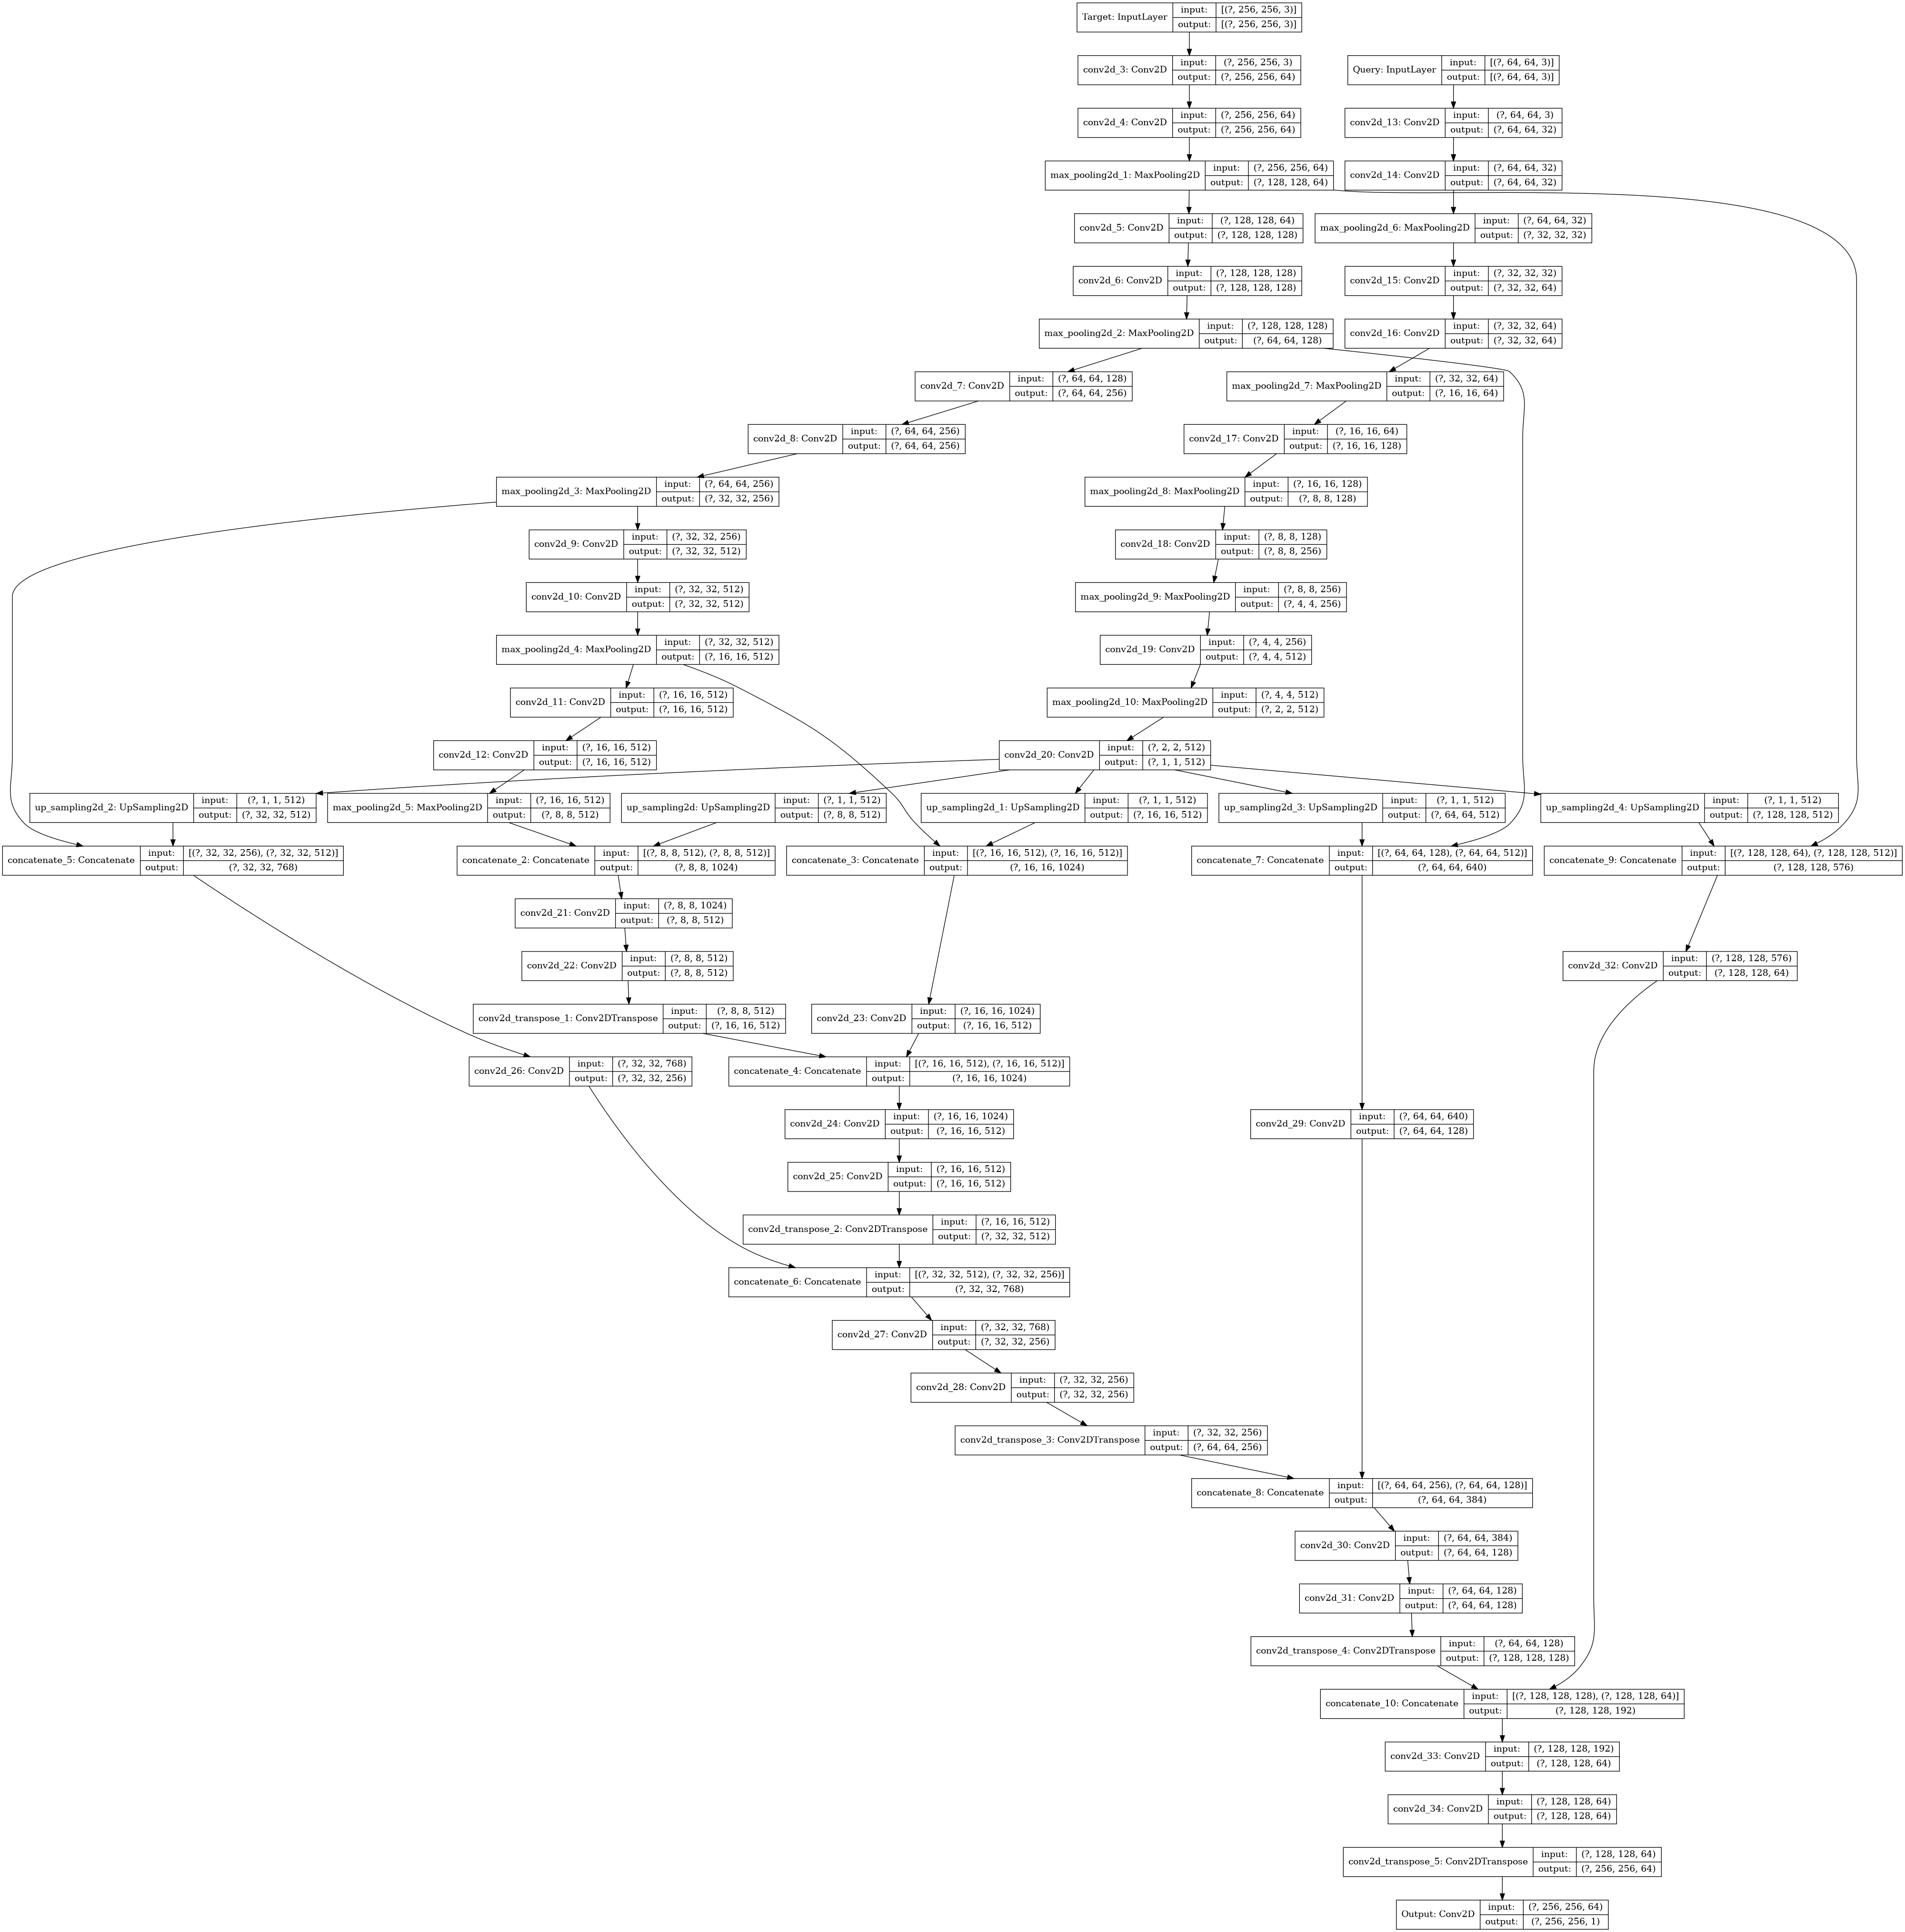

In [48]:
tf.keras.utils.plot_model(modelUnet, "unet_model.png", show_shapes=True)

# Przygotowanie danych

In [49]:
import os
MASKS_PATH = '/qarr/studia/magister/datasets/FlickrLogos-v2/classes/masks/'
INPUT_PATH = '/qarr/studia/magister/datasets/FlickrLogos-v2/classes/jpg/'

classes = [o for o in os.listdir(INPUT_PATH) if os.path.isdir(INPUT_PATH + '/' + o)]
classes = [o for o in classes if o != 'no-logo']


In [50]:
print(classes)

['adidas', 'aldi', 'apple', 'becks', 'bmw', 'carlsberg', 'chimay', 'cocacola', 'corona', 'dhl', 'erdinger', 'esso', 'fedex', 'ferrari', 'ford', 'fosters', 'google', 'guiness', 'heineken', 'hp', 'milka', 'nvidia', 'paulaner', 'pepsi', 'rittersport', 'shell', 'singha', 'starbucks', 'stellaartois', 'texaco', 'tsingtao', 'ups']


## Wczytywanie obrazków do pamięci

In [51]:
images = dict()
targets = dict()
queries = dict()
start_time = time.time()

def rescale(nparray, scale=255.0):
    return np.array(nparray, dtype=np.float32)/scale

for c in classes:
    root_input = INPUT_PATH + '/' + c 
    root_masks = MASKS_PATH + '/' + c
    images[c] = list()
    targets[c] = list()
    queries[c] = list()
    
    for f in os.listdir(root_input):
        img = cv2.imread(f'{root_input}/{f}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(f'{root_masks}/{f}.mask.merged.png', cv2.IMREAD_GRAYSCALE)
        bboxes = []
        
        with open(f'{root_masks}/{f}.bboxes.txt') as csvfile:
            bboxread = csv.reader(csvfile, delimiter=' ')
            next(bboxread)
            for row in bboxread:
                bboxes.append(row)
                
        for bbox in bboxes:
            x,y,w,h = [int(i) for i in bbox]
            imgslice = img[y:y+h, x:x+w]
            imgslice = cv2.resize(imgslice, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
            queries[c].append(rescale(imgslice, 255.0))
            # Biore tylko pierwszy z dostepnych bbox na obrazku
            break 
            
        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
        mask = cv2.resize(mask, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    
        images[c].append(rescale(img, 255.0))
        targets[c].append(rescale(mask, 255.0))


end_time = time.time()

print(f'Time taken: {end_time-start_time} seconds')


Time taken: 20.169958114624023 seconds


## Generowanie listy labeli dla wczytanych obrazków

In [52]:
images_labels = list()
targets_labels = list()
queries_labels = list()

for c in classes:
    images_labels += [classes.index(c)] * len(images[c])
    queries_labels += [classes.index(c)] * len(queries[c])
targets_labels = images_labels

## Wczytane przykłady obrazków

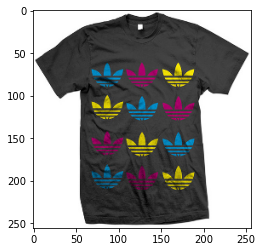

In [53]:
for v in images.values():
    plt.imshow(v[0])
    break

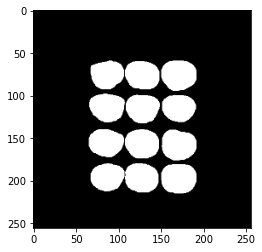

In [54]:
for v in targets.values():
    plt.imshow(v[0], cmap='gist_gray')
    break

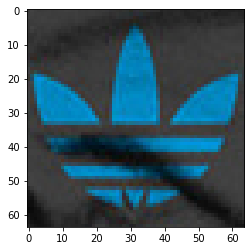

In [55]:
for v in queries.values():
    plt.imshow(v[0])
    break

# Tworzenie tymczasowych datasets

In [56]:
sumimgs = sum(images.values(), [])
sumtargs = sum(targets.values(), [])
sumquers = sum(queries.values(), [])

In [57]:
#images_dataset = tf.data.Dataset.from_tensor_slices((sumimgs, sumtargs, images_labels))

In [58]:
#queries_dataset = tf.data.Dataset.from_tensor_slices((sumquers, queries_labels))

In [59]:
for c in classes:
    print(f'{c:>12}: {len(images[c])} logos: {len(queries[c]):3<} pairs: {len(images[c])*len(queries[c])}')
print(f'{"total":<12}: {sum([len(images[c]) for c in classes])} logos: {sum([len(queries[c]) for c in classes])} pairs: {sum([len(images[c])*len(queries[c]) for c in classes])}')

      adidas: 70 logos: 70 pairs: 4900
        aldi: 70 logos: 70 pairs: 4900
       apple: 70 logos: 70 pairs: 4900
       becks: 70 logos: 70 pairs: 4900
         bmw: 70 logos: 70 pairs: 4900
   carlsberg: 70 logos: 70 pairs: 4900
      chimay: 70 logos: 70 pairs: 4900
    cocacola: 70 logos: 70 pairs: 4900
      corona: 70 logos: 70 pairs: 4900
         dhl: 70 logos: 70 pairs: 4900
    erdinger: 70 logos: 70 pairs: 4900
        esso: 70 logos: 70 pairs: 4900
       fedex: 70 logos: 70 pairs: 4900
     ferrari: 70 logos: 70 pairs: 4900
        ford: 70 logos: 70 pairs: 4900
     fosters: 70 logos: 70 pairs: 4900
      google: 70 logos: 70 pairs: 4900
     guiness: 70 logos: 70 pairs: 4900
    heineken: 70 logos: 70 pairs: 4900
          hp: 70 logos: 70 pairs: 4900
       milka: 70 logos: 70 pairs: 4900
      nvidia: 70 logos: 70 pairs: 4900
    paulaner: 70 logos: 70 pairs: 4900
       pepsi: 70 logos: 70 pairs: 4900
 rittersport: 70 logos: 70 pairs: 4900
       shell: 70 logos: 7

In [24]:
print(f"{32*(70*69)*(64*64*3+256*256*4)*8/1e9} GB vs {32*(70)*(64*64*3+256*256*4)*8/1e9} GB")

339.32967936 GB vs 4.91782144 GB


Gdyby brać pod uwagę każde logo z obrazka:
```
      adidas: 70 logos: 120 pairs: 8400
        aldi: 70 logos: 106 pairs: 7420
       apple: 70 logos: 76 pairs: 5320
       becks: 70 logos: 100 pairs: 7000
         bmw: 70 logos: 74 pairs: 5180
   carlsberg: 70 logos: 108 pairs: 7560
      chimay: 70 logos: 112 pairs: 7840
    cocacola: 70 logos: 130 pairs: 9100
      corona: 70 logos: 83 pairs: 5810
         dhl: 70 logos: 123 pairs: 8610
    erdinger: 70 logos: 105 pairs: 7350
        esso: 70 logos: 87 pairs: 6090
       fedex: 70 logos: 94 pairs: 6580
     ferrari: 70 logos: 73 pairs: 5110
        ford: 70 logos: 76 pairs: 5320
     fosters: 70 logos: 98 pairs: 6860
      google: 70 logos: 83 pairs: 5810
     guiness: 70 logos: 98 pairs: 6860
    heineken: 70 logos: 103 pairs: 7210
          hp: 70 logos: 112 pairs: 7840
       milka: 70 logos: 197 pairs: 13790
      nvidia: 70 logos: 114 pairs: 7980
    paulaner: 70 logos: 102 pairs: 7140
       pepsi: 70 logos: 178 pairs: 12460
 rittersport: 70 logos: 204 pairs: 14280
       shell: 70 logos: 96 pairs: 6720
      singha: 70 logos: 83 pairs: 5810
   starbucks: 70 logos: 95 pairs: 6650
stellaartois: 70 logos: 87 pairs: 6090
      texaco: 70 logos: 88 pairs: 6160
    tsingtao: 70 logos: 109 pairs: 7630
         ups: 70 logos: 90 pairs: 6300
total       : 2240 logos: 3404 pairs: 238280
```

In [60]:
def dataset_permutations_generator(batch_size):
    nclasses = len(classes)
    nlogos = sum([len(images[c]) for c in classes])//nclasses
    data_permutations = np.zeros((nclasses*nlogos*(nlogos-1), 3), dtype=np.int8)
    i = 0
    for c_i in range(nclasses):
        for n_i in range(nlogos):
            for l_i in range(nlogos):
                if n_i == l_i:
                    continue
                data_permutations[i] = (c_i, n_i, l_i)
                i += 1
    data_permutations = np.random.permutation(data_permutations)
    for class_number, image_number, query_number in data_permutations:
        c = classes[class_number]
        yield (images[c][image_number], queries[c][query_number], targets[c][image_number])

In [61]:
unetDataset = tf.data.Dataset.from_generator(dataset_permutations_generator, (tf.float32, tf.float32, tf.float32),
                                            output_shapes=([256,256,3],
                                                          [64,64,3],
                                                          [256,256,1]))
unetDataset = unetDataset.batch(32).cache()

# Zestawienie modelu i uczenie - próba

In [62]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0004, momentum=0.9, nesterov=False, name="SGD") # weight decay 0.0005

modelUnet.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [63]:
#modelUnet.fit(unetDataset, epochs=1, steps_per_epoch=32)

In [64]:
gen_inst = dataset_permutations_generator()
custom_batch = [next(gen_inst) for i in range(32)]

In [114]:
testDataset = tf.data.Dataset.from_tensor_slices((
                                                  ([a for a,b,c in custom_batch], [b for a,b,c in custom_batch]),
                                                  ([np.reshape(c, (256,256,1)) for a,b,c in custom_batch],)
                                                 )
                                                )
testDataset = testDataset.batch(32)
#timgs, tquers, ttargs = ([a for a,b,c in custom_batch], [b for a,b,c in custom_batch], [c for a,b,c in custom_batch])

In [116]:
img = custom_batch[0][0]
qry = custom_batch[0][1]

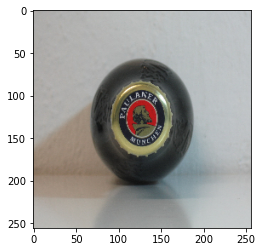

In [118]:
plt.imshow(img)

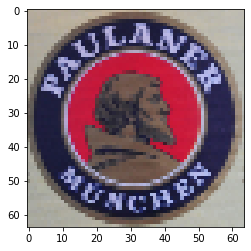

In [120]:
plt.imshow(qry)

In [125]:
modelUnet.predict({"Target":img, "Query":qry})

ValueError: Data cardinality is ambiguous:
  x sizes: 64, 256
Please provide data which shares the same first dimension.

In [108]:
a = [i for i in testDataset]
a = a[0]
a[0][1].shape

TensorShape([32, 64, 64, 3])

In [110]:
modelUnet.fit(testDataset, epochs=1, steps_per_epoch=32)

TypeError: 'NoneType' object is not callable

In [134]:
from tensorflow import keras
from tensorflow.keras import layers
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = keras.Input(
    shape=(num_tags,), name="tags"
)  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],)
    
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        keras.losses.BinaryCrossentropy(from_logits=True),
        keras.losses.CategoricalCrossentropy(from_logits=True),
    ],
    loss_weights=[1.0, 0.2],
)

# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32,
)


Epoch 1/2
40/40 [==============================] - 0s 10ms/step - loss: 1.3202 - priority_loss: 0.7000 - department_loss: 3.1012
Epoch 2/2
40/40 [==============================] - 0s 10ms/step - loss: 1.2894 - priority_loss: 0.6957 - department_loss: 2.9682


In [21]:
testInput1 = tf.keras.Input(dtype = tf.float32, shape = [16, 16, 3], name = 'Input1')
testInput2 = tf.keras.Input(dtype = tf.float32, shape = [8, 8, 3], name = 'Input2')

Tconv1 = tf.keras.layers.Conv2D(filters = 8, kernel_size = 3, strides = 1, padding='SAME', 
               activation = tf.nn.relu)(testInput1) 

Tpool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides = 2, padding = 'SAME')(Tconv1)

Tconv2 = tf.keras.layers.Conv2D(filters = 8, kernel_size = 3, strides = 1, padding='SAME', 
               activation = tf.nn.relu)(testInput2)
Tconcat = tf.keras.layers.Concatenate(axis=-1)([Tpool1, Tconv2]) # -> [8,8,16]

Tconv3 = tf.keras.layers.Conv2D(filters = 8, kernel_size = 1, strides = 1, padding='SAME',
                   activation=tf.nn.relu)(Tconcat) # -> [8, 8, 8]

Tupsam = tf.keras.layers.Conv2DTranspose(filters=8, kernel_size = 3,
                   strides=(2,2), padding='SAME', activation = tf.nn.relu)(Tconv3)

Tconv4 = tf.keras.layers.Conv2D(filters = 1, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu, name="Toyoutput")(Tupsam)  

toyModel = tf.keras.Model(inputs=[testInput1, testInput2], outputs=[Tconv4], name="Toynet")


In [2]:
testInput1 = tf.keras.Input(dtype = tf.float32, shape = [8, 8, 3], name = 'Input1')
testInput2 = tf.keras.Input(dtype = tf.float32, shape = [8, 8, 3], name = 'Input2')


Tconcat = tf.keras.layers.Concatenate(axis=-1)([testInput1, testInput2]) # -> [8,8,16]

Tconv4 = tf.keras.layers.Conv2D(filters = 1, kernel_size = 3, strides = 1, padding='SAME', 
                   activation = tf.nn.relu, name="Toyoutput")(Tconcat)  

toyModel = tf.keras.Model(inputs=[testInput1, testInput2], outputs=[Tconv4], name="Toynet")

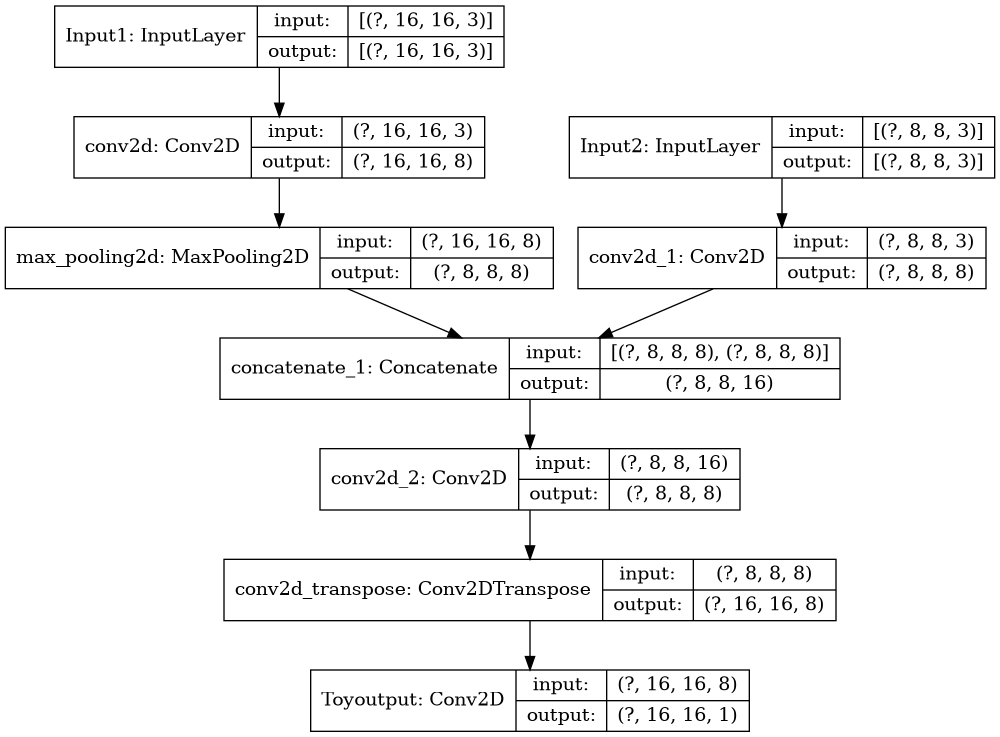

In [22]:
tf.keras.utils.plot_model(toyModel, "toymodel.png", show_shapes=True)

In [29]:
# minibatch = [ 
#     (cv2.resize(a, dsize=(8, 8), interpolation=cv2.INTER_CUBIC),
#      cv2.resize(b, dsize=(8, 8), interpolation=cv2.INTER_CUBIC),
#      cv2.resize(c, dsize=(8, 8), interpolation=cv2.INTER_CUBIC))
#     for a,b,c in custom_batch
# ]
minibatch = [
    (np.random.random((16,16,3)),
    np.random.random((8,8,3)),
    np.random.random((16,16)))
    for i in range(32)
]


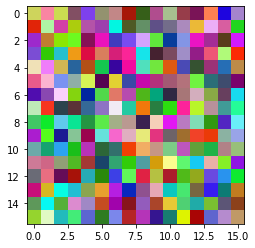

In [30]:
plt.imshow(minibatch[0][0])

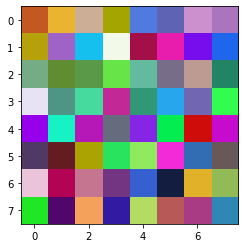

In [31]:
plt.imshow(minibatch[0][1])

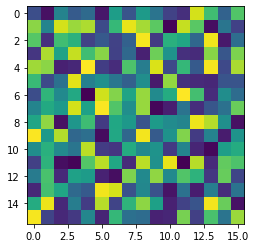

In [32]:
plt.imshow(minibatch[0][2])

In [33]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0004, momentum=0.9, nesterov=False, name="SGD") # weight decay 0.0005

toyModel.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

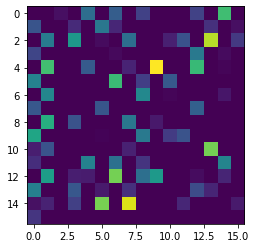

In [35]:
plt.imshow(np.reshape(toyModel.predict([np.reshape(minibatch[0][0], (1,16,16,3)), np.reshape(minibatch[0][1], (1,8,8,3))]), (16,16)))

In [36]:

X = [np.reshape([a for a,b,c in minibatch], (32,16,16,3)), np.reshape([b for a,b,c in minibatch], (32,8,8,3))]
Y = [np.reshape([c for a,b,c in minibatch], (32,16,16,1))]
toyDataset = tf.data.Dataset

In [37]:
print([x.shape for x in X])
print([y.shape for y in Y])

[(32, 16, 16, 3), (32, 8, 8, 3)]
[(32, 16, 16, 1)]


In [38]:

toyModel.fit(x={'Input1':X[0], 'Input2':X[1]}, y={'Toyoutput':Y[0]})

1/1 [==============================] - 0s 784us/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


In [201]:
Y[0].shape

(32, 16, 16, 1)

In [192]:
for b in X:
    print(f'{len(b[0])} {len(b[0][0])} {len(b[0][0][0])}')
    print(b[0].shape)
    print(b[1].shape)

1 8 8
(1, 8, 8, 3)
(1, 8, 8, 3)
1 16 16
(1, 16, 16, 3)
(1, 16, 16, 3)
